# Práctica 3

**IDS330L, Feb-Abr 2023**

1. Jugar con la estructura de la red (página 47 del libro)
2. Cambiar a Tensorflow (paginas 50-55 del libro)


In [ ]:
import numpy as np

In [ ]:
class FullyConnectedLayer(object):
    """A simple fully-connected NN layer.
    Args:
        num_inputs (int): The input vector size / number of input values.
        layer_size (int): The output vector size / number of neurons in the layer.
        activation_function (callable): The activation function for this layer.
    Attributes:
        W (ndarray): The weight values for each input.
        b (ndarray): The bias value, added to the weighted sum.
        size (int): The layer size / number of neurons.
        activation_function (callable): The activation function computing the neuron's output.
        x (ndarray): The last provided input vector, stored for backpropagation.
        y (ndarray): The corresponding output, also stored for backpropagation.
        derivated_activation_function (callable): The corresponding derivated function for backpropagation.
        dL_dW (ndarray): The derivative of the loss, with respect to the weights W.
        dL_db (ndarray): The derivative of the loss, with respect to the bias b.
    """

    def __init__(self, num_inputs, layer_size, activation_function, derivated_activation_function=None):
        super().__init__()

        # Randomly initializing the weight vector and the bias value (using a normal distribution this time):
        self.W = np.random.standard_normal((num_inputs, layer_size))
        self.b = np.random.standard_normal(layer_size)
        self.size = layer_size

        self.activation_function = activation_function
        self.derivated_activation_function = derivated_activation_function
        self.x, self.y = None, None
        self.dL_dW, self.dL_db = None, None

    def forward(self, x):
        """
        Forward the input vector through the layer, returning its activation vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`
        Returns:
            activation (ndarray): The activation value, of shape `(batch_size, layer_size)`.
        """
        z = np.dot(x, self.W) + self.b
        self.y = self.activation_function(z)
        self.x = x  # (we store the input and output values for back-propagation)
        return self.y

    def backward(self, dL_dy):
        """
        Back-propagate the loss, computing all the derivatives, storing those w.r.t. the layer parameters,
        and returning the loss w.r.t. its inputs for further propagation.
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the layer's output (dL/dy = l'_{k+1}).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the layer's input (dL/dx).
        """
        dy_dz = self.derivated_activation_function(self.y)  # = f'
        dL_dz = (dL_dy * dy_dz) # dL/dz = dL/dy * dy/dz = l'_{k+1} * f'
        dz_dw = self.x.T
        dz_dx = self.W.T
        dz_db = np.ones(dL_dy.shape[0]) # dz/db = d(W.x + b)/db = 0 + db/db = "ones"-vector

        # Computing the derivatives with respect to the layer's parameters, and storing them for opt. optimization:
        self.dL_dW = np.dot(dz_dw, dL_dz)
        self.dL_db = np.dot(dz_db, dL_dz)

        # Computing the derivative with respect to the input, to be passed to the previous layers (their `dL_dy`):
        dL_dx = np.dot(dL_dz, dz_dx)
        return dL_dx

    def optimize(self, epsilon):
        """
        Optimize the layer's parameters, using the stored derivative values.
        Args:
            epsilon (float): The learning rate.
        """
        self.W -= epsilon * self.dL_dW
        self.b -= epsilon * self.dL_db  

In [ ]:
def sigmoid(x):             # sigmoid function
    y = 1 / (1 + np.exp(-x))
    return y


def derivated_sigmoid(y):   # sigmoid derivative function
    return y * (1 - y)

def loss_L2(pred, target):             # L2 loss function
    return np.sum(np.square(pred - target)) / pred.shape[0] # opt. we divide by the batch size


def derivated_loss_L2(pred, target):   # L2 derivative function
    return 2 * (pred - target)

def binary_cross_entropy(pred, target):            # cross-entropy loss function
    return -np.mean(np.multiply(np.log(pred), target) + np.multiply(np.log(1 - pred), (1 - target)))


def derivated_binary_cross_entropy(pred, target):  # cross-entropy derivative function
    return (pred - target) / (pred * (1 - pred))

In [ ]:
class SimpleNetwork(object):
    """A simple fully-connected NN.
    Args:
        num_inputs (int): The input vector size / number of input values.
        num_outputs (int): The output vector size.
        hidden_layers_sizes (list): A list of sizes for each hidden layer to add to the network
        activation_function (callable): The activation function for all the layers
        derivated_activation_function (callable): The derivated activation function
        loss_function (callable): The loss function to train this network
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation
    Attributes:
        layers (list): The list of layers forming this simple network.
        loss_function (callable): The loss function to train this network.
        derivated_loss_function (callable): The derivative of the loss function, for back-propagation.
    """

    def __init__(self, num_inputs, num_outputs, hidden_layers_sizes=(64, 32),
                 activation_function=sigmoid, derivated_activation_function=derivated_sigmoid,
                 loss_function=loss_L2, derivated_loss_function=derivated_loss_L2):
        super().__init__()
        # We build the list of layers composing the network, according to the provided arguments:
        layer_sizes = [num_inputs, *hidden_layers_sizes, num_outputs]
        self.layers = [
            FullyConnectedLayer(layer_sizes[i], layer_sizes[i + 1], 
                                activation_function, derivated_activation_function)
            for i in range(len(layer_sizes) - 1)]

        self.loss_function = loss_function
        self.derivated_loss_function = derivated_loss_function

    def forward(self, x):
        """
        Forward the input vector through the layers, returning the output vector.
        Args:
            x (ndarray): The input vector, of shape `(batch_size, num_inputs)`.
        Returns:
            activation (ndarray): The output activation value, of shape `(batch_size, layer_size)`.
        """
        for layer in self.layers: # from the input layer to the output one
            x = layer.forward(x)
        return x

    def predict(self, x):
        """
        Compute the output corresponding to input `x`, and return the index of the largest 
        output value.
        Args:
            x (ndarray): The input vector, of shape `(1, num_inputs)`.
        Returns:
            best_class (int): The predicted class ID.
        """
        estimations = self.forward(x)
        best_class = np.argmax(estimations)
        return best_class

    def backward(self, dL_dy):
        """
        Back-propagate the loss hrough the layers (require `forward()` to be called before).
        Args:
            dL_dy (ndarray): The loss derivative w.r.t. the network's output (dL/dy).
        Returns:
            dL_dx (ndarray): The loss derivative w.r.t. the network's input (dL/dx).
        """
        for layer in reversed(self.layers): # from the output layer to the input one
            dL_dy = layer.backward(dL_dy)
        return dL_dy

    def optimize(self, epsilon):
        """
        Optimize the network parameters according to the stored gradients (require `backward()`
        to be called before).
        Args:
            epsilon (float): The learning rate.
        """
        for layer in self.layers:             # the order doesn't matter here
            layer.optimize(epsilon)

    def evaluate_accuracy(self, X_val, y_val):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
        Returns:
            accuracy (float): The accuracy of the network 
                              (= number of correct predictions/dataset size).
        """
        num_corrects = 0
        for i in range(len(X_val)):
            pred_class = self.predict(X_val[i])
            if pred_class == y_val[i]:
                num_corrects += 1
        return num_corrects / len(X_val)

    def train(self, X_train, y_train, X_val=None, y_val=None, 
              batch_size=32, num_epochs=5, learning_rate=1e-3, print_frequency=20):
        """
        Given a dataset and its ground-truth labels, evaluate the current accuracy of the network.
        Args:
            X_train (ndarray): The input training dataset.
            y_train (ndarray): The corresponding ground-truth training dataset.
            X_val (ndarray): The input validation dataset.
            y_val (ndarray): The corresponding ground-truth validation dataset.
            batch_size (int): The mini-batch size.
            num_epochs (int): The number of training epochs i.e. iterations over the whole dataset.
            learning_rate (float): The learning rate to scale the derivatives.
            print_frequency (int): Frequency to print metrics (in epochs).
        Returns:
            losses (list): The list of training losses for each epoch.
            accuracies (list): The list of validation accuracy values for each epoch.
        """
        num_batches_per_epoch = len(X_train) // batch_size
        do_validation = X_val is not None and y_val is not None
        losses, accuracies = [], []
        for i in range(num_epochs): # for each training epoch
            epoch_loss = 0
            for b in range(num_batches_per_epoch):  # for each batch composing the dataset
                # Get batch:
                batch_index_begin = b * batch_size
                batch_index_end = batch_index_begin + batch_size
                x = X_train[batch_index_begin: batch_index_end]
                targets = y_train[batch_index_begin: batch_index_end]
                # Optimize on batch:
                predictions = y = self.forward(x)  # forward pass
                L = self.loss_function(predictions, targets)  # loss computation
                dL_dy = self.derivated_loss_function(predictions, targets)  # loss derivation
                self.backward(dL_dy)  # back-propagation pass
                self.optimize(learning_rate)  # optimization of the NN
                epoch_loss += L

            # Logging training loss and validation accuracy, to follow the training:
            epoch_loss /= num_batches_per_epoch
            losses.append(epoch_loss)
            if do_validation:
                accuracy = self.evaluate_accuracy(X_val, y_val)
                accuracies.append(accuracy)
            else:
                accuracy = np.NaN
            if i % print_frequency == 0 or i == (num_epochs - 1):
                print("Epoch {:4d}: training loss = {:.6f} | val accuracy = {:.2f}%".format(
                    i, epoch_loss, accuracy * 100))
        return losses, accuracies

In [ ]:
%matplotlib inline
import matplotlib          # We use this package to visualize some data and results
import matplotlib.pyplot as plt
from keras.datasets import mnist 

np.random.seed(42)

# Preparamos los datos de las imágenes
(X_train, y_train), (X_test, y_test) = mnist.load_data()

num_classes = 10    # classes are the digits from 0 to 9

# Cambia las imágenes de matrices 28x28 a vectores 1x784
X_train, X_test = X_train.reshape(-1, 28 * 28), X_test.reshape(-1, 28 * 28)
print("Pixel values between {} and {}".format(X_train.min(), X_train.max()))

# Normaliza los vectores
X_train, X_test = X_train / 255., X_test / 255.
print("Normalized pixel values between {} and {}".format(X_train.min(), X_train.max()))
y_train = np.eye(num_classes)[y_train] 


Pixel values between 0 and 255
Normalized pixel values between 0.0 and 1.0


# Cambiar la estructura de la red

Para cambiar la manera en la que la red predice la información, podemos variar la su composición interna, como la la cantidad de capas  ocultas o la función de activación.

En este caso, manipularemos la cantidad o el tamaño de las capas, para determinar si esto tiene algún resultado distinto.

Hay que tener cuidado con los tamaños de las redes, pues se cambian la cantidad de parámetros que hay que manipular (los coeficientes para las sumas y multiplicaciones).

Podemos crear una red con una estructura específica con algo como

```python
clasificador_numeros = SimpleNetwork(num_inputs=X_train.shape[1], num_outputs=num_classes, hidden_layers_sizes=[64, 32])
```

donde las capas internas son de 64 y 32 neuronas respectivamente.

Entrenamos el clasificador con algo como:

```python
print("Entrenando a 80 epochs:")
losses, accuracies = clasificador_numeros.train(X_train, y_train, X_test, y_test, batch_size=30, num_epochs=80)

```

Un dato importante a considerar es que nuestra clase `FullyConnectedLayer` para el clasificador está siendo creada con una capa de entrada con 784 neuronas (verifique probando el valor que devuelve `X_train.shape[1]`, que se usa al crear la red).

Esto implica que la ecuación (pg. 33)

$$ z = x \cdot W + B $$

donde $W$ y $B$ combinan los vectores de ganancias y bias de cada neurona, tiene una cantidad considerable de coeficientes (ganancias y bias) que calcular. Por tanto, hay que elegir apropiadamente el número y tamaño de capas ocultas.

# Ejercicio

### 1. Analice y escriba cuántos coeficientes (ganancias y bias) se necesitan para una red que acepte como entrada 784 valores, tenga dos capas ocultas de 64 y 32 neuronas, y 10 neuronas en la capa de salida. Justifique.

Para determinar el número de coeficientes necesarios para la red neuronal descrita, es necesario contar los pesos y los sesgos (biases) de cada capa de la red.

1. La primera capa oculta tiene 64 neuronas, cada una de las cuales acepta una entrada de 784 valores. Por lo tanto, hay un total de 784 x 64 pesos y 64 sesgos. Es decir, 50,176 pesos y 64 sesgos.

2. La segunda capa oculta tiene 32 neuronas, cada una de las cuales está conectada a las 64 neuronas de la capa anterior. Por lo tanto, hay un total de 64 x 32 pesos y 32 sesgos. Es decir, 2,048 pesos y 32 sesgos.

3. La capa de salida tiene 10 neuronas, cada una de las cuales está conectada a las 32 neuronas de la capa anterior. Por lo tanto, hay un total de 32 x 10 pesos y 10 sesgos. Es decir, 320 pesos y 10 sesgos.

Por lo tanto, el número total de coeficientes necesarios para la red neuronal es la suma de los pesos y sesgos de todas las capas.

#### **Total de pesos**: 50,176 + 2,048 + 320 = 52,544 pesos
#### **Total de sesgos**: 64 + 32 + 10 = 106 sesgos

**En resumen, se necesitan 52,544 pesos y 106 sesgos para la red neuronal descrita.**

### 2. Seleccione de 8 imágenes elegidas aleatoriamente de las imágenes de prueba `X_test`.

In [ ]:
indices_muestra_prueba = np.random.randint(0, X_test.shape[0], 8)
print("Índices de las imágenes seleccionadas: {}".format(indices_muestra_prueba))

Índices de las imágenes seleccionadas: [7270  860 5390 5191 5734 6265  466 4426]


### 3. Cree una red con dos capas internas de 64 neuronas, entrenela a por lo menos 100 `epochs` y pruébela con las 8 imágenes

In [ ]:
red_64x64 = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[64, 64])

In [ ]:
print("Entrenando dos capas internas de 64 neuronas a 100 epochs:")
losses, accuracies = red_64x64.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=100) 

Entrenando a 100 epochs:
Epoch    0: training loss = 1.813961 | val accuracy = 10.10%
Epoch   20: training loss = 0.233353 | val accuracy = 85.92%
Epoch   40: training loss = 0.165759 | val accuracy = 89.67%
Epoch   60: training loss = 0.137067 | val accuracy = 91.22%
Epoch   80: training loss = 0.120047 | val accuracy = 91.95%
Epoch   99: training loss = 0.108769 | val accuracy = 92.50%


In [ ]:
print("Probando red de dos capas internas de 64 neuronas :")
# Predecir el número mostrado en cada una de las 8 imágenes
for img in indices_muestra_prueba:
    predicted_class = red_64x64.predict(np.expand_dims(X_test[img], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img]))


Pruebando red de 64+64 :
Predicted class: 1; Correct class: 1
Predicted class: 6; Correct class: 6
Predicted class: 2; Correct class: 2
Predicted class: 4; Correct class: 4
Predicted class: 7; Correct class: 3
Predicted class: 4; Correct class: 4
Predicted class: 8; Correct class: 8
Predicted class: 9; Correct class: 9


### 4. Cree una red con dos capas internas de 32 y 64,  entrene a por lo menos 100 `epochs` y pruébela con las 8 imágenes


In [ ]:
red_32x64 = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[32, 64])

In [ ]:
print("Entrenando a 100 epochs:")
losses, accuracies = red_32x64.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=100) 

Entrenando a 100 epochs:
Epoch    0: training loss = 0.986174 | val accuracy = 33.18%
Epoch   20: training loss = 0.404536 | val accuracy = 69.58%
Epoch   40: training loss = 0.288028 | val accuracy = 78.93%
Epoch   60: training loss = 0.162546 | val accuracy = 89.93%
Epoch   80: training loss = 0.138734 | val accuracy = 91.07%
Epoch   99: training loss = 0.124725 | val accuracy = 91.82%


In [ ]:
print("Probando red de 32+64 neuronas:")
# Predecir el número mostrado en cada una de las 8 imágenes
for img in indices_muestra_prueba:
    predicted_class = red_32x64.predict(np.expand_dims(X_test[img], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img]))


Probando red de 32+64 neuronas:
Predicted class: 1; Correct class: 1
Predicted class: 6; Correct class: 6
Predicted class: 2; Correct class: 2
Predicted class: 4; Correct class: 4
Predicted class: 7; Correct class: 3
Predicted class: 4; Correct class: 4
Predicted class: 8; Correct class: 8
Predicted class: 9; Correct class: 9


### 5. Cree una red con una capa interna de 128 neuronas,  entrene a por lo menos 100 `epochs` y pruébela con las 8 imágenes.


In [ ]:
red_128 = SimpleNetwork(num_inputs=X_train.shape[1], 
                                 num_outputs=num_classes, hidden_layers_sizes=[128])

In [ ]:
print("Entrenando a 100 epochs:")
losses, accuracies = red_128.train(X_train, y_train, X_test, y_test, 
                                            batch_size=30, num_epochs=100) 

Entrenando a 100 epochs:
Epoch    0: training loss = 1.109149 | val accuracy = 18.48%
Epoch   20: training loss = 0.492672 | val accuracy = 60.69%
Epoch   40: training loss = 0.427887 | val accuracy = 64.37%
Epoch   60: training loss = 0.332027 | val accuracy = 74.06%
Epoch   80: training loss = 0.238351 | val accuracy = 83.16%
Epoch   99: training loss = 0.215936 | val accuracy = 83.98%


In [ ]:
print("Probando red de 128 neuronas:")
# Predecir el número mostrado en cada una de las 8 imágenes
for img in indices_muestra_prueba:
    predicted_class = red_128.predict(np.expand_dims(X_test[img], 0))
    print('Predicted class: {}; Correct class: {}'.format(predicted_class, y_test[img]))


Probando red de 128 neuronas:
Predicted class: 1; Correct class: 1
Predicted class: 6; Correct class: 6
Predicted class: 2; Correct class: 2
Predicted class: 4; Correct class: 4
Predicted class: 4; Correct class: 3
Predicted class: 4; Correct class: 4
Predicted class: 8; Correct class: 8
Predicted class: 4; Correct class: 9


### 6. Compare los resultados, ¿qué diferencia cree que haya entre cada una?

#### Resultados

*Asumiendo que todas fueron probadas con 8 imagenes y 100 epochs*

1. Red 64x64: 92.50% Accuracy
2. Red 32*64: 91.82% Accuracy
3. Red 128: 83.98% Accuracy

Podemos ver que los mejores reusultados se obtuvieron con dos capas de 64 neuronas lo que nos confirma que una gran capa de neuronas no nos sirve para nuestro modelo de predicción de números naturales.

**Los mejores resultados deben estar en una o más capas de unas 32 a 64 neuronas**

### 7. ¿Cuántos coeficientes hubo en cada una?


#### Coeficientes

##### **Red 64x64**

**Total de pesos**
1. Capa 1: 784 * 64 = 50,176 pesos
2. Capa 2: 784 * 64 = 50,176 pesos

**50,176 * 2 = 100,352 pesos**

**Total de bias**
1. Capa 1: 64 = 64 bias
2. Capa 2: 64 = 64 bias

**64 * 2 = 128 bias**

##### **Red 32*64**

**Total de pesos**
1. Capa 1: 784 * 32 = 25,088 pesos
2. Capa 2: 784 * 64 = 50,176 pesos

**25,088 + 50,176 = 75,264 pesos**

**Total de bias**
1. Capa 1: 32 = 64 bias
2. Capa 2: 64 = 64 bias

**32 + 64 = 96 bias**

##### **Red 128**

**Total de pesos**
1. Capa 1: 784 * 128 = 100,352 pesos

**100,352 pesos**

**Total de bias**
1. Capa 1: 128 = 128 bias

**128 bias**

### 8. Corra el código debajo, basado en _Tensorflow_ (**explicado en pgs. 50-55** del libro) y compare la precisión de validación (`val_accuracy`) y el número de _epochs_ con la red del punto 5. Ambas tienen la misma estructura.


## Trabajar con Tensorflow


Usaremos _Tensorflow_ para la misma tarea, siguiendo el ejemplo del libro. En este caso, la librería incluye su versión de las imágenes del set de datos MNIST con el que hemos trabajado.

In [ ]:
import tensorflow as tf

Preparar las imágenes. Necesita conexión a internet para la primera vez.

In [ ]:
num_classes = 10
img_rows, img_cols = 28, 28
num_channels = 1
input_shape = (img_rows, img_cols, num_channels)

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

### Modelo simple de una red clasificadora

Este modelo se explica en la página 53 del libro.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

### Entrenamiento de una red en TensorFlow

Explicado en la página 54.

El método `compile()` debe ser llamado antes del entrenamiento (método `fit()`).



In [ ]:
model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
callbacks = [tf.keras.callbacks.TensorBoard('./keras')]
model.fit(x_train, y_train, epochs=25, verbose=1, validation_data=(x_test, y_test), callbacks=callbacks)

Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6750 - accuracy: 0.8310 - val_loss: 0.3593 - val_accuracy: 0.9011
Epoch 2/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3390 - accuracy: 0.9068 - val_loss: 0.2934 - val_accuracy: 0.9196
Epoch 3/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2888 - accuracy: 0.9192 - val_loss: 0.2618 - val_accuracy: 0.9268
Epoch 4/25
1875/1875 [==============================] - 9s 5ms/step - loss: 0.2581 - accuracy: 0.9274 - val_loss: 0.2360 - val_accuracy: 0.9317
Epoch 5/25
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2348 - accuracy: 0.9344 - val_loss: 0.2198 - val_accuracy: 0.9367
Epoch 6/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2164 - accuracy: 0.9395 - val_loss: 0.2016 - val_accuracy: 0.9419
Epoch 7/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2005 - accuracy: 0.9435 - val_loss: 0.1890 - val_accuracy:

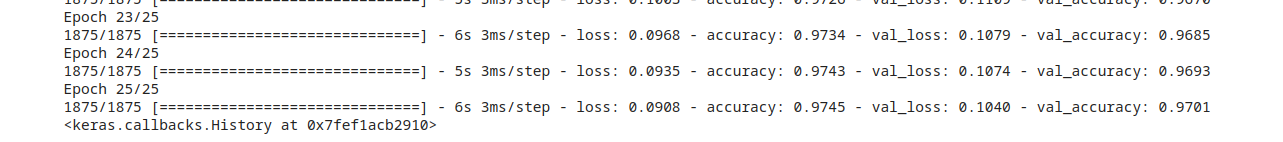

# Resultados

### Aqui estamos probando nuestro modelo con 50 imagenes

In [ ]:
random_list = np.random.randint(0, 11, size=50)


In [ ]:
for number in random_list:
  image_index = 0
  test_image = x_test[number]
  test_label = y_test[number]

  # Reshape the image to match the input shape of the model
  test_image = test_image.reshape(1, img_rows, img_cols, num_channels)

  # Use the model to predict the class of the image
  predicted_probs = model.predict(test_image)
  predicted_class = tf.argmax(predicted_probs, axis=1)[0].numpy()

  # Print the results
  print('Test image label:', test_label)
  print('Predicted class:', predicted_class)

1/1 [==============================] - 0s 42ms/step
Test image label: 9
Predicted class: 9
1/1 [==============================] - 0s 40ms/step
Test image label: 0
Predicted class: 0
1/1 [==============================] - 0s 43ms/step
Test image label: 9
Predicted class: 9
1/1 [==============================] - 0s 42ms/step
Test image label: 9
Predicted class: 9
1/1 [==============================] - 0s 41ms/step
Test image label: 7
Predicted class: 7
1/1 [==============================] - 0s 43ms/step
Test image label: 4
Predicted class: 4
1/1 [==============================] - 0s 44ms/step
Test image label: 4
Predicted class: 4
1/1 [==============================] - 0s 46ms/step
Test image label: 9
Predicted class: 9
1/1 [==============================] - 0s 65ms/step
Test image label: 7
Predicted class: 7
1/1 [==============================] - 0s 39ms/step
Test image label: 1
Predicted class: 1
1/1 [==============================] - 0s 45ms/step
Test image label: 1
Predicted class: 1